### Data Science Interviews Group Study (Spring 2017)
- Brian Goodness
- Assignment 1: Conversion Rates

In [16]:
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np

### load data; inspect

In [17]:
df = pd.read_csv('conversion_data.csv')

In [18]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [19]:
df.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [20]:
# tabulate method
def tab(frame, field):
    result = pd.DataFrame(df[field].value_counts())
    result['percent'] = result[field]/result[field].sum()*100
    return result

In [21]:
# crosstab method (to include percentages)
def crosstab_pcts(frame, row, column):
    ctab = pd.crosstab(df[row], df[column])
    for field in ctab.columns:
        ctab['%s_pct' % field] = ctab[field]/ctab[field].sum()*100
    return ctab

In [22]:
# tabulate fields, see splits
for field in ['country','new_user','source','converted']:
    print('\nField: %s' % field)
    print(tab(frame=df,field=field))


Field: country
         country    percent
US        178092  56.322581
China      76602  24.225806
UK         48450  15.322581
Germany    13056   4.129032

Field: new_user
   new_user   percent
1    216744  68.54649
0     99456  31.45351

Field: source
        source    percent
Seo     155040  49.032258
Ads      88740  28.064516
Direct   72420  22.903226

Field: converted
   converted    percent
0     306000  96.774194
1      10200   3.225806


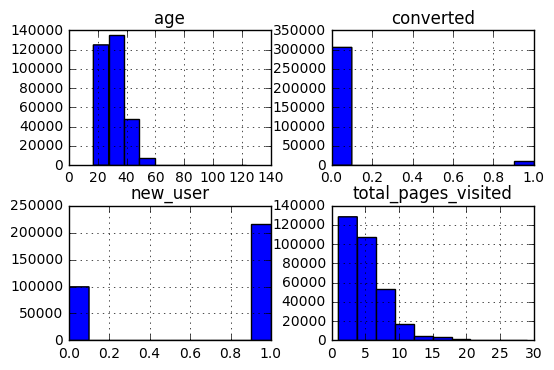

In [23]:
df.hist()
pl.show()

In [24]:
#cross-tab: new_user on conversion
crosstab_pcts(df, 'converted', 'new_user')

new_user,0,1,0_pct,1_pct
converted,,,,
0,92295,213705,92.799831,98.597885
1,7161,3039,7.200169,1.402115


In [25]:
#cross-tab: source on conversion
crosstab_pcts(df, 'converted', 'source')

source,Ads,Direct,Seo,Ads_pct,Direct_pct,Seo_pct
converted,,,,,,
0,85680,70380,149940,96.551724,97.183099,96.710526
1,3060,2040,5100,3.448276,2.816901,3.289474


In [26]:
#cross-tab: country on conversion
crosstab_pcts(df, 'converted', 'country')

country,China,Germany,UK,US,China_pct,Germany_pct,UK_pct,US_pct
converted,,,,,,,,
0,76500,12240,45900,171360,99.866844,93.75,94.736842,96.219931
1,102,816,2550,6732,0.133156,6.25,5.263158,3.780069


In [27]:
#cross-tab: country on source
ctab = pd.crosstab(df['source'], df['country'])
for field in ctab.columns:
    ctab['%s_pct' % field] = ctab[field]/ctab[field].sum()*100
ctab

country,China,Germany,UK,US,China_pct,Germany_pct,UK_pct,US_pct
source,,,,,,,,
Ads,21561,3760,13518,49901,28.146785,28.799020,27.900929,28.019788
Direct,17463,2864,11131,40962,22.797055,21.936275,22.974200,23.000472
Seo,37578,6432,23801,87229,49.056160,49.264706,49.124871,48.979741


In [29]:
# create dummy variables for categorical variables (e.g., country, source)
# see http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
country_dummies = pd.get_dummies(df['country'])
source_dummies = pd.get_dummies(df['source'])
merged = df.join(country_dummies.ix[:, 'Germany':]) # exclude China dummy
merged = merged.join(source_dummies.ix[:, 'Direct':]) # exclude Ads dummy

In [30]:
# apply logistic regression on 'converted' field
# see http://blog.yhat.com/posts/logistic-regression-and-python.html
train_cols = ['age','new_user','total_pages_visited','Germany','UK','US','Direct','Seo']
logit = sm.Logit(merged['converted'], merged[train_cols])
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.057774
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               316200
Model:                          Logit   Df Residuals:                   316192
Method:                           MLE   Df Model:                            7
Date:                Mon, 30 Jan 2017   Pseudo R-squ.:                  0.5946
Time:                        09:58:39   Log-Likelihood:                -18268.
converged:                       True   LL-Null:                       -45060.
                                        LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
age                    -0.2486      0.002   -128.310      0.000        -0.252    -0.245
n

In [35]:
# print the log odds ratio (of the coefficients)
print(np.exp(result.params))

age                    0.779891
new_user               0.108647
total_pages_visited    1.815574
Germany                1.563388
UK                     1.273494
US                     0.878716
Direct                 0.346108
Seo                    0.408389
dtype: float64


#### Findings
- The number of pages visited by the user in a session had the strongest positive effect on conversion rates.
- On country vs. likelihood of conversion: the base (reference) case was China, which proportionally had the fewest conversions, so it was not surprising that being from Germany, the UK, and the US all had positive effects. Moreover, Germany had relatively more conversions and fewer users overall, which carried more weight on the fit.
- Being a new user has a 1 in 11 chance in converting (vs. being a repeat visitor).
- Direct sourcing and SEO both had negative effects on conversion rates, when compared to the base case (Ads).

In [32]:
# study number of pages visited: bin/stratify users into four groups based on # pages visited (1,2,3-6,7+)
# see pandas.cut() http://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
df.total_pages_visited.describe()

count    316200.000000
mean          4.872966
std           3.341104
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          29.000000
Name: total_pages_visited, dtype: float64